# Library Imports

In [480]:
# import libraries
import pandas as pd
import numpy as np
import scipy.fftpack
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.signal import argrelextrema
from sklearn.model_selection import train_test_split


import scipy.fftpack
%matplotlib inline

In [52]:
position_labels={
    'layingdown':0,
    'sitting':1,
    'standing':2,
    'walking':3,
}

# Data Loader Functions

In [371]:
def create_dataset(path, timesteps):
    X = []
    y = []
    positions = ['layingdown','sitting','standing','walking']
    print(path)
    for ip, p in enumerate(positions):
        data = []
        with open(path+p+'/1_android.sensor.accelerometer.data.csv') as f:
            # ts = find_sampling_freq(path, p)
            # if ts == 0:
            ts = timesteps
            print('\tsampling freq = %i'% ts)
            row = []
            for i, line in enumerate(f):
                row.append([float(x) for x in line.split(',')[1:4]])
                if len(row) == ts:
                    data.append(np.stack(row))
                    row = []
        data = np.stack(data)
        print("\t%s : %i examples loaded" % (p, data.shape[0]))
        X.append(data)
        y.append(np.zeros(data.shape[0])+ip)

    X = np.vstack(X)
    y = np.concatenate(y)
    # print(X.shape, y.shape)
    return (X, y)

def pull_raw_data(path, position):
    #sampling freq = 250Hz

    num_lines = subprocess.call(['wc', '-l', path])
    num_secs = num_lines/(250*60)
    X = []
    with open(path) as f:
        for i, line in enumerate(f):
            X.append([float(x) for x in line.split(',')[1:4]])
            
    y = np.zeros(len(X))+position_labels[position]
    return np.asarray(X), y

# Filters 

In [308]:
import subprocess

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    # Plot the frequency response.
    """
    w, h = freqz(b, a, worN=8000)
    plt.subplot(2, 1, 1)
    plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
    plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
    plt.axvline(cutoff, color='k')
    plt.xlim(0, 0.5*fs)
    plt.title("Lowpass Filter Frequency Response")
    plt.xlabel('Frequency [Hz]')
    plt.grid()
    """
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def split_accel_axes(data):
    #assumes 2 axis 
    samples, axes = data.shape
    x = data[:,0]
    y = data[:,1]
    z = data[:,2]
    return x,y,z



# Data Visualization 

In [417]:
X_walk, y_walk = pull_raw_data('data/train/walking/1_android.sensor.accelerometer.data.csv',
                                position='walking')

X_stand, y_stand = pull_raw_data('data/train/standing/1_android.sensor.accelerometer.data.csv',
                                position='standing')

X_sit, y_sit = pull_raw_data('data/train/sitting/1_android.sensor.accelerometer.data.csv',
                                position='sitting')

X_lay, y_lay = pull_raw_data('data/train/layingdown/1_android.sensor.accelerometer.data.csv',
                                position='layingdown')

## Visualizing Walking 
We expect a periodic signal that's sinusoidal. 

In [418]:
def plot_axis(data, title, x_name, y_name, range):
    f = plt.figure(1)
    plt.plot(np.arange(len(data)), data)
    plt.title(title+' whole signal')
    plt.ylabel(y_name)
    plt.xlabel(x_name)
    f.show()


    g = plt.figure(2)
    plt.plot(np.arange(range), data[0:range]) 
    plt.title(title+' zoomed in signal')
    plt.ylabel(y_name)
    plt.xlabel(x_name)
    g.show()



### X-axis
While the whole signal does not appear to exhibit any periodicity, it's clear from the zoomed in plot that the signal is periodic. It's extremely noisy though. 

/Users/Jonny/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


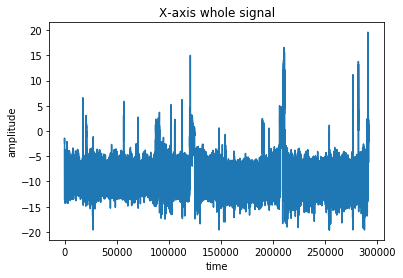

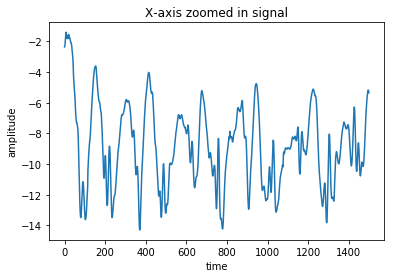

In [419]:
#split by axis into x,y,z
x_sp, y_sp, z_sp = split_accel_axes(X_walk)

#plotting x
plot_axis(x_sp, title='X-axis', x_name='time', y_name='amplitude', range=1500)

### Y-axis
Visualizing the y-axis signals. The first plot shows that there are extremely high amplitude peaks, which will correspond to high frequency components. These are likely outliers and will need to be removed. The zoomed in plot only shows the first 1500 steps and does not include any of the outlier points. However, it's still a periodic signal.

/Users/Jonny/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


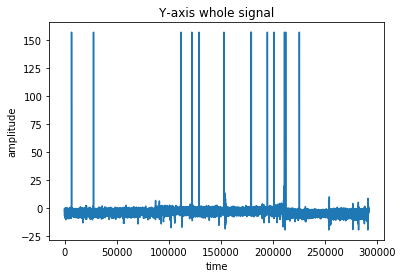

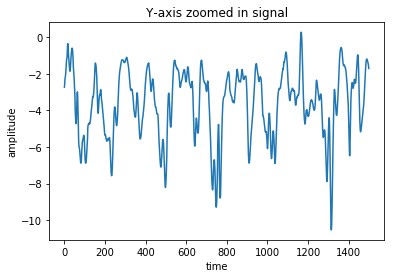

In [420]:
#plotting y
plot_axis(y_sp, title='Y-axis', x_name='time', y_name='amplitude', range=1500)

### Z-axis
Z-axis visualization. This axis also exhibits periodicity but the amplitude of the signals is less. The plot on the bottom shows a range of 5000, because it's not immediately clear from the first plot that this signal is characteristically sinusoidal.

/Users/Jonny/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


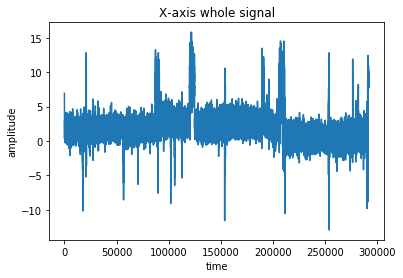

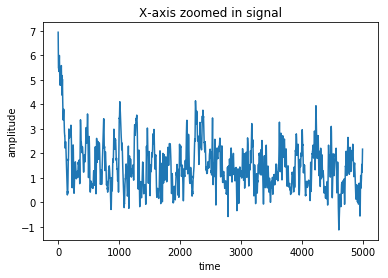

In [421]:
#plotting z
plot_axis(z_sp, title='X-axis', x_name='time', y_name='amplitude', range=5000)

### Takeaways from Walking Visualizations
All three accelerometer axes for walking are sinusoidal as expected. Therefore, it would make sense to clean the data and then perform a frequency domain transformation. Data cleaning will involve removing outliers and performing curve smoothing via Savitzky-Golay. Removing sharp edges is a form of low pass filtering.

## Visualizing Laying Down
We expect this to just be essentially a flatline with some noise for the occasional movement.

### X-axis
As expected, laying down has no periodicity because there is supposed to be no movement. The points of movement are likely a combination of noise and occsional arm movement; it's impossible to be fully still, even when sleeping! 

In [422]:
#split by axis into x,y,z
x_ld, y_ld, z_ld = split_accel_axes(X_lay)

/Users/Jonny/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


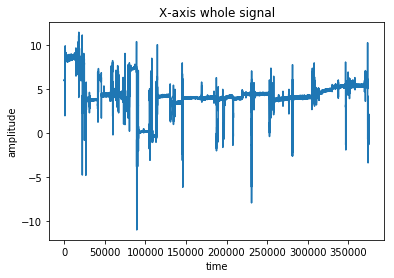

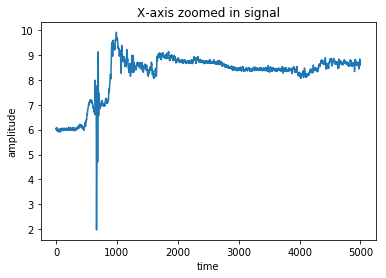

In [423]:
plot_axis(x_ld, title='X-axis', x_name='time', y_name='amplitude', range=5000)

### Y-axis

/Users/Jonny/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


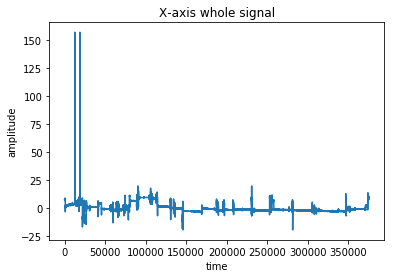

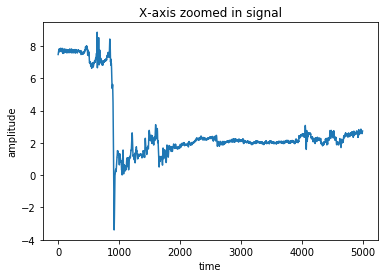

In [424]:
plot_axis(y_ld, title='X-axis', x_name='time', y_name='amplitude', range=5000)

### Z-axis

/Users/Jonny/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


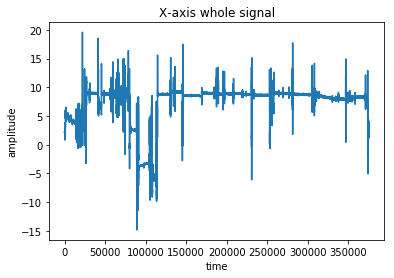

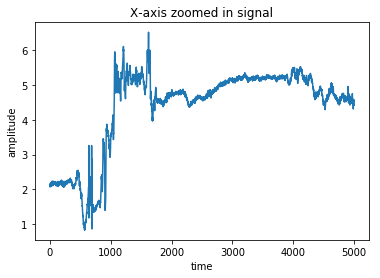

In [425]:
plot_axis(z_ld, title='X-axis', x_name='time', y_name='amplitude', range=5000)

## Visualizing Standing Up
We expected this to look essentially the same as laying down.

In [426]:
#split by axis into x,y,z
x_su, y_su, z_su = split_accel_axes(X_stand)

### X-axis
It appears that the wearer moved several times with the device. These are not periodic signals even though they resemble a distorted and shifted square wave. It's likely that the wearer moved into one position and then moved back into the previous one

/Users/Jonny/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


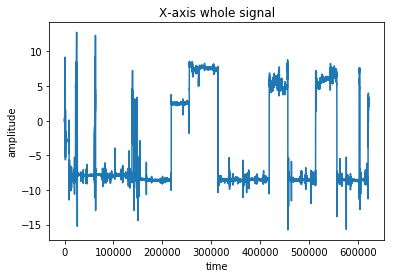

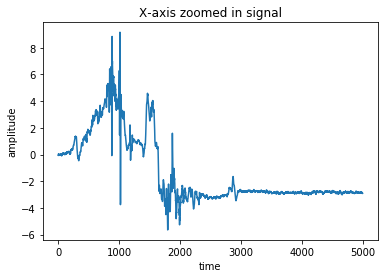

In [427]:
plot_axis(x_su, title='X-axis', x_name='time', y_name='amplitude', range=5000)

### Y-axis

/Users/Jonny/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


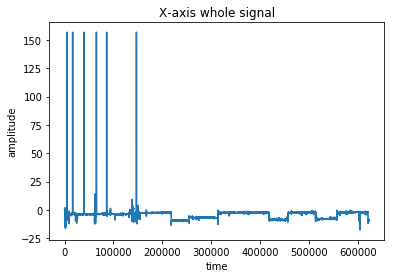

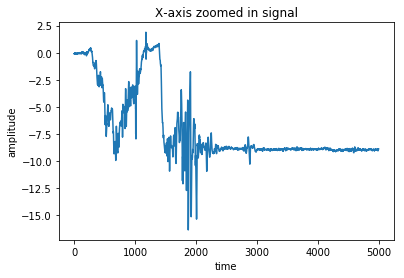

In [428]:
plot_axis(y_su, title='X-axis', x_name='time', y_name='amplitude', range=5000)

### Z-axis

/Users/Jonny/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


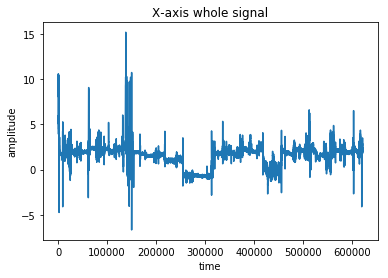

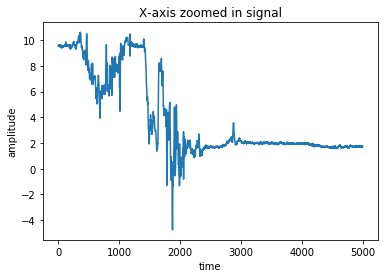

In [429]:
plot_axis(z_su, title='X-axis', x_name='time', y_name='amplitude', range=5000)

## Visualizing Sitting
Also expecting to see a flatline with some peaks from occasional movement.

In [430]:
#split by axis into x,y,z
x_si, y_si, z_si = split_accel_axes(X_sit)

### X-axis

/Users/Jonny/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


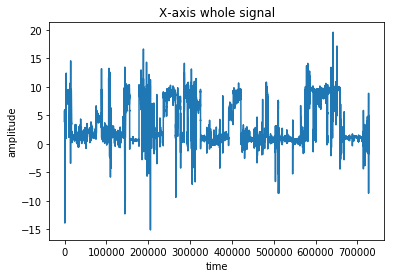

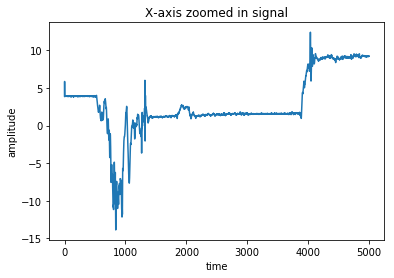

In [431]:
plot_axis(x_si, title='X-axis', x_name='time', y_name='amplitude', range=5000)

### Y-axis

/Users/Jonny/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


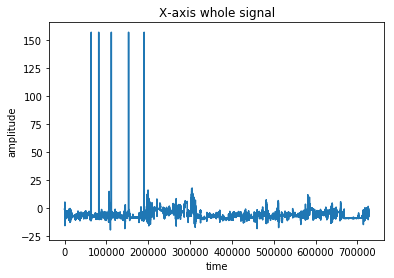

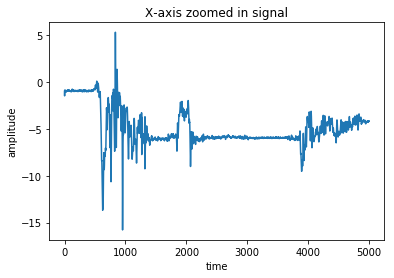

In [432]:
plot_axis(y_si, title='X-axis', x_name='time', y_name='amplitude', range=5000)

### Z-axis

/Users/Jonny/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


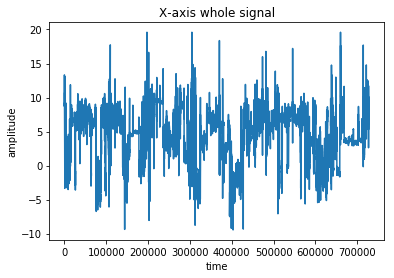

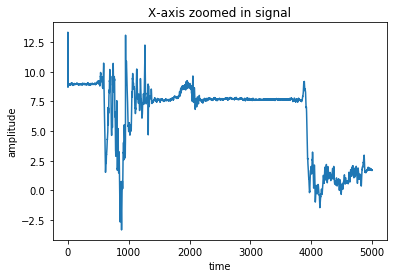

In [433]:
plot_axis(z_si, title='X-axis', x_name='time', y_name='amplitude', range=5000)

# Data Interpretation 
As expected, walking is periodic whereas the other signals are not. There are occasional peaks in the other signals from when the wearer moved slightly. Extremely high frequency peaks can be removed but sustained movement cannot be "filtered" out without distorting the signal too much and the integrity of the data. <br> <br>
For the walking data, we will apply Savitzky-Golay curve smoothing to remove some of the rough edges. The other signals will be low pass filtered. A frequency domain transform such as an FFT really only makes sense for walking, where there is some degree of periodicity. For the other activities that are essentially all DC-components, it's useless. Therefore, the input to a model would ideally be some combination of a frequency domain representation along with either the signals themselves or other data. There's no way that a learning algorithm would be able to tell the difference between sitting, standing, and lying down from a frequency domain representation because in the ideal case there is no movement. FFT or similar type of transform would be sufficient if the task was to classify different movement patters.

# Data Preprocessing

In [434]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

def reject_xyz_outliers(x,y,z):
    return reject_outliers(x), reject_outliers(y), reject_outliers(z)

#Basic outlier reject and mean shift
def perform_preprocessing(x, y, z):
    x = reject_outliers(x)
    y = reject_outliers(y)
    z = reject_outliers(z)
    
    #zero mean 
    x = x - np.mean(x)
    y = y - np.mean(y)
    z = z - np.mean(z)
    
    return x,y,z

#Savitzky-Golay curve smoothing
def smooth_curve(x,y,z, window_size=51, polynomial=3):
    x_hat = scipy.signal.savgol_filter(x, window_size, polynomial)
    y_hat = scipy.signal.savgol_filter(y, window_size, polynomial)
    z_hat = scipy.signal.savgol_filter(z, window_size, polynomial)
    
    return x_hat, y_hat, z_hat

In [446]:
#suffix p to denote post processing
#walking
x_wp, y_wp, z_wp = reject_xyz_outliers(x_sp, y_sp, z_sp)

#laying down 
x_ldp, y_ldp, z_sdp = reject_xyz_outliers(x_ld, y_ld, z_ld)

#sitting
x_sitp, y_sitp, z_sitp = reject_xyz_outliers(x_si, y_si, z_si)

#standing
x_stp, y_stp, z_stp = reject_xyz_outliers(x_su, y_su, z_su)

### Curve Smoothing 
Shown below is the "walking" curve after outliers are rejected, zero-mean, and curve smoothing is applied. The same technique is applied to other signals.

/Users/Jonny/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


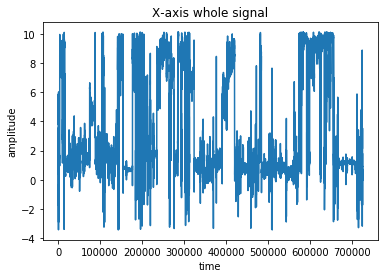

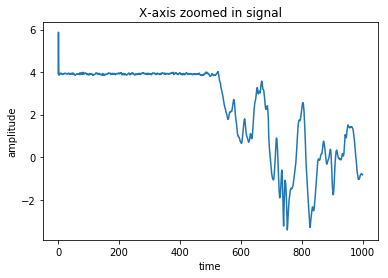

In [447]:
# spell out the args that were passed to the Matlab function
x_sp_hat = scipy.signal.savgol_filter(x_sp, 51, 3)
plot_axis(x_sitp, title='X-axis', x_name='time', y_name='amplitude', range=1000)


In [448]:
#suffix p to denote post processing
#walking
x_wp, y_wp, z_wp = smooth_curve(x_wp, y_wp, z_wp)

#laying down 
x_ldp, y_ldp, z_sdp = smooth_curve(x_ldp, y_ldp, z_sdp)

#sitting
x_sitp, y_sitp, z_sitp = smooth_curve(x_sitp, y_sitp, z_sitp)

#standing
x_stp, y_stp, z_stp = smooth_curve(x_stp, y_stp, z_stp)

# Data Processing

In [464]:
#plt.subplot(2, 1,1)
order = 5
xwp_filtered = butter_bandpass_filter(x_wp, 0.1, 25, 250, order)
ywp_filtered = butter_bandpass_filter(y_wp, 0.1, 25, 250, order)
zwp_filtered = butter_bandpass_filter(z_wp, 0.1, 25, 250, order)

(array([97]),)


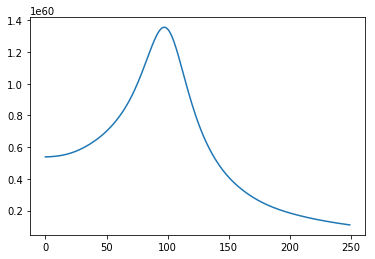

In [465]:
freqx = np.fft.rfft(xwp_filtered)
freqx = np.abs(freqx)
max_x = argrelextrema(freqx, np.greater)
print(max_x)

plt.plot(freqx[:250])



(array([104]),)


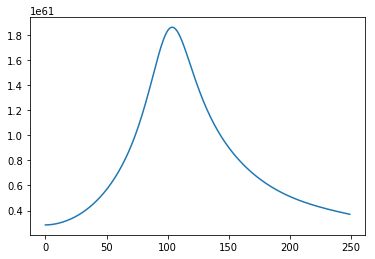

In [466]:
freqy = np.fft.rfft(ywp_filtered)
freqy = np.abs(freqy)
max_y = argrelextrema(freqy, np.greater)
print(max_y)
plt.plot( freqy[:250])

(array([102]),)


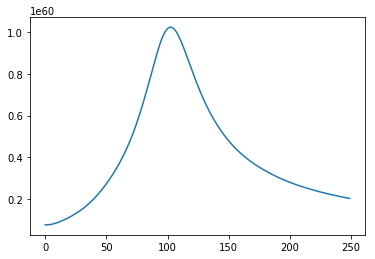

In [467]:
freqz = np.fft.rfft(zwp_filtered)
freqz = np.abs(freqz)
max_z = argrelextrema(freqz, np.greater)
print(max_z)
plt.plot(freqz[:250])

# Model

## Pull in data

In [530]:
X, y = create_dataset('data/train/', timesteps=750)
X_time, y_time = create_dataset('data/train/', timesteps=250)

data/train/
	sampling freq = 750
	layingdown : 500 examples loaded
	sampling freq = 750
	sitting : 970 examples loaded
	sampling freq = 750
	standing : 829 examples loaded
	sampling freq = 750
	walking : 389 examples loaded
data/train/
	sampling freq = 250
	layingdown : 1502 examples loaded
	sampling freq = 250
	sitting : 2910 examples loaded
	sampling freq = 250
	standing : 2487 examples loaded
	sampling freq = 250
	walking : 1168 examples loaded


In [531]:
#one hot encoding for y (keras)
def create_one_hot(vec):
    vec_new = []
    for val in vec:
        if val == 0:
            vec_new.append([1,0,0,0])
        elif val == 1:
            vec_new.append([0,1,0,0])
        elif val == 2: 
            vec_new.append([0,0,1,0])
        elif val == 3:
            vec_new.append([0,0,0,1])

    return vec_new



In [532]:
#print(X.shape)
#print(y.shape)

#Perform 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_oh = np.asarray(create_one_hot(y))
y_test_oh = np.asarray(create_one_hot(y_test))
y_train_oh = np.asarray(create_one_hot(y_train))

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2150, 750, 3)
(2150,)
(538, 750, 3)
(538,)


In [533]:
#For each chunk, go through and perform preprocessing then take FFT
def get_ffts(data):
    x_ffts = []
    y_ffts = []
    z_ffts = []
    for sample in data:
        x, y, z = split_accel_axes(sample)
        x, y, z = reject_xyz_outliers(x, y, z)
        x, y, z = smooth_curve(x, y, z)
        x_filtered = butter_bandpass_filter(x, 0.1, 25, 250, )
        y_filtered = butter_bandpass_filter(y, 0.1, 25, 250, 5)
        z_filtered = butter_bandpass_filter(z, 0.1, 25, 250, 5)

        #take FFTs
        freqx = np.fft.rfft(x_filtered)
        freqx = np.abs(freqx)
        max_x = argrelextrema(freqx, np.greater)

        freqy = np.fft.rfft(y_filtered)
        freqy = np.abs(freqy)
        max_y = argrelextrema(freqy, np.greater)

        freqz = np.fft.rfft(z_filtered)
        freqz = np.abs(freqz)
        max_z = argrelextrema(freqz, np.greater)


        #only keep data up to the sampling frequency 
        x_ffts.append(freqx[0:250].reshape(250, 1))
        y_ffts.append(freqy[0:250].reshape(250, 1))
        z_ffts.append(freqz[0:250].reshape(250, 1))

    x_ffts = np.asarray(x_ffts)
    y_ffts = np.asarray(y_ffts)
    z_ffts = np.asarray(z_ffts)
    
    return x_ffts, y_ffts, z_ffts

In [534]:
x_ffts, y_ffts, z_ffts = get_ffts(X)
x_ffts_test, y_ffts_test, z_ffts_test = get_ffts(X_test)
x_ffts_train, y_ffts_train, z_ffts_train = get_ffts(X_train)

In [535]:
print(x_ffts_train.shape)
print(y_ffts_train.shape) 
print(z_ffts_train.shape)

(2150, 250, 1)
(2150, 250, 1)
(2150, 250, 1)


In [536]:
from keras.models import Sequential
from keras.constraints import maxnorm
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, LSTM, Merge




Two branch network architecture <br>
branch1: raw signal input <br>
branch2: 3 FFTs fed into individual LSTMs for spectrum recognition  <br>

The idea here is that if there is periodic information, branch 2 will be able to pick it up and activate output neurons corresponding to the walking class. This is an extendable model since it would allow for more types of classification, such as running, sprinting, or really anything with periodicity. If there is no frequency information, such as in the case of lying down, sitting, or standing, the left branch will be able to determine the action by the waveforms alone. With more sensors, more branches could be added and output layers essentially act as the final decision maker or selector of which branch to use.


In [537]:
dropout=0.2
recurrent_dropout = 0.0

branch1 = Sequential()
branch1.add(LSTM(100, input_shape=(750, 3), dropout=dropout, recurrent_dropout=dropout))
branch1.add(Dense(4))


#branch 2 requires sub-branches 2_x, 2_y, 2_z
branch2_x = Sequential()
branch2_x.add(LSTM(100, input_shape=(250, 1), dropout=dropout, recurrent_dropout=dropout))
branch2_x.add(Dense(4))

branch2_y = Sequential()
branch2_y.add(LSTM(100, input_shape=(250, 1), dropout=dropout, recurrent_dropout=dropout))
branch2_x.add(Dense(4))

branch2_z = Sequential()
branch2_z.add(LSTM(100, input_shape=(250, 1), dropout=dropout, recurrent_dropout=dropout))
branch2_z.add(Dense(4))

branch2 = Sequential()
branch2.add(Merge([branch2_x, branch2_y, branch2_z], mode='concat'))
branch2.add(Dense(4))

#Merge the two branches
model = Sequential()
model.add(Merge([branch1, branch2], mode='concat'))
model.add(Dense(4, activation='softmax')) #final output layer

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

#model.fit([X_train, x_ffts_train, y_ffts_train, z_ffts_train], y_train_oh, epochs = 3)
model.fit([X, x_ffts, y_ffts, z_ffts], y_oh, validation_split=0.2, epochs = 3 )

/Users/Jonny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/Jonny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_28 (Merge)             (None, 8)                 0         
_________________________________________________________________
dense_88 (Dense)             (None, 4)                 36        
Total params: 165,704
Trainable params: 165,704
Non-trainable params: 0
_________________________________________________________________
Train on 2150 samples, validate on 538 samples
Epoch 1/3
2150/2150 [==============================] - 85s 40ms/step - loss: 0.6259 - acc: 0.7288 - val_loss: 7.0740 - val_acc: 0.1691
Epoch 2/3
2150/2150 [==============================] - 72s 33ms/step - loss: 0.3694 - acc: 0.8502 - val_loss: 8.8767 - val_acc: 0.1766
Epoch 3/3
 256/2150 [==>...........................] - ETA: 1:04 - loss: 0.3207 - acc: 0.8711

KeyboardInterrupt: 

In [ ]:
model.evaluate([X_test, x_ffts_test, y_ffts_test, z_ffts_test], y_test_oh)